# Imports

In [63]:
#Imports
%matplotlib widget
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
import scipy
import datetime
import networkx as nx
import misc
import math
import random

# Data Generation

In [64]:
#Create empty graph
G = nx.Graph()

In [65]:
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

G.add_edges_from([
    (0,1),
    (1,2),
    (2,3),
    (3,4),
    (4,5),
    (5,6),
    (6,7),
    (7,8),
    (8,9),
    (9,0),

    (0,2),
    (0,3),
    (0,4),
    (1,3)
])

# Common items

In [66]:
G = nx.Graph()  # The complete graph
d = 3   # Amount of levels
staticColoring = {}   # Coloring at any moment
bucketLevels = []

In [220]:
class Bucket:

  vertices: set = set({})
  coloring: dict = {}

  def __init__(self, size, level):
      self.size = size
      self.level = level

  def addVertices(self, newVertices):
    self.vertices = self.vertices.union(newVertices)
    for vertex in newVertices:
        G.nodes[vertex]['bucket'] = self

  def removeVertices(self, removeVertices):
    self.vertices = self.vertices.difference(removeVertices)
    for vertex in removeVertices:
        G.nodes[vertex]['bucket'] = None
        self.coloring.pop(vertex, None)


In [68]:
# Returns whether there is still an empty bucket on the requested level
# Also returns the index of this bucket, if applicable
def isEmptyBucketOnLevel(level: int) -> tuple[bool, int]:
    for j in range(0, len(bucketLevels[level])):
        bucket = bucketLevels[level][j]
        if len(bucket.vertices) == 0:
                return (True, j)
    return (False, -1)

In [212]:
# Empties all buckets on a level and returns the union of all vertices
# Also ensures the colorings and vertex lists in the emptied buckets are reset
def emptyLevel(level: int):
    vertices: set = set({})
    for bucket in bucketLevels[level]:
        vertices = vertices.union(bucket.vertices)
        bucket.removeVertices(bucket.vertices)
    return vertices

# Small Bucket Algorithm

In [194]:
# Creates brand new buckets with the correct sizes
def resetBuckets(G: nx.Graph):
    nx.set_node_attributes(G, None, 'bucket')   # Reset all bucket references in G to None
    nr = G.number_of_nodes()    # Number of vertices in G
    s = math.ceil(pow(nr, 1/d)) # Amount of buckets per level
    s = max(1, s)               # To allow the algorithm to work with empty graphs as well

    # Create d levels of s buckets each, with capacity s^i per bucket, where i the level of the bucket
    global bucketLevels
    bucketLevels = []
    for level in range(0, d):
        bucketLevel = []
        for b in range(0, s):
            bucketLevel.append(Bucket(pow(s, level), level))
        bucketLevels.append(bucketLevel)
    bucketLevels.append([Bucket(nr, d)])
    
    global staticColoring
    staticColoring = nx.coloring.greedy_color(G)
    

In [86]:
# Update bucket contents and recolor subgraphs
def updateBuckets(b: Bucket):
    b = b
    i = 0
    while i < d:
        # If there is still an empty bucket on a level, this level does not need updating
        # Simply recompute the coloring of the most recent bucket and return
        if isEmptyBucketOnLevel(i)[0]:
            b.coloring = nx.coloring.greedy_color(G.subgraph(b.vertices))
            return
        else:
            # Else, empty all level i buckets into a single level i+1 bucket, update b to point at new bucket
            vertices = emptyLevel(i)
            b = bucketLevels[i+1][isEmptyBucketOnLevel(i+1)[1]]
            b.addVertices(vertices)
            i += 1
    resetBuckets(G)
    return

In [244]:
def removeEdge(s, t):
    if not G.has_edge(s, t):    # Potentially redundant
        print("Edge not present in graph")
        return
    G.remove_edge(s, t)

def removeVertex(v):

    if not G.has_node(v):   # Potentially redundant
        print("Node not present in graph")
        return

    b = G.nodes[v]['bucket']
    if b != None:
        b.removeVertices([v])
    G.remove_node(v)

def addEdge(s, t):

    if G.has_edge(s, t):    # Potentially redundant, but could be extended to also check if the vertices are present yet
        print("Edge already in the graph")
        return
    if (not G.has_node(s) or not G.has_node(t)):
        print("Not all nodes present in graph yet")
        return


    G.add_edge(s, t)
    # Select one of the endpoints at random, remove it from a bucket and add it as usual
    if bool(random.getrandbits(1)):
        v = s
    else:
        v = t
        
    b = G.nodes[v]['bucket']
    if b != None:
        b.removeVertices([v])
    
    # Add vertex to an empty bucket
    bucket = bucketLevels[0][isEmptyBucketOnLevel(0)[1]]
    bucket.addVertices([v])
    updateBuckets(bucket)

def addVertex(v):
    if G.has_node(v):   # Potentially redundant, depending on the input used during the experiments
        print("Node already present in graph")
        return
    G.add_node(v)
    bucket = bucketLevels[0][isEmptyBucketOnLevel(0)[1]]
    bucket.addVertices([v])
    updateBuckets(bucket)

In [236]:
def getColoring():
    bucketColorings = [staticColoring]
    for bucketLevel in bucketLevels:
        for bucket in bucketLevel:
            bucketColorings.append(bucket.coloring)
    combinedColoring = misc.combineColorings(bucketColorings)   
    return combinedColoring      

In [74]:
def printBucketLevels(bls):
    for bl in bls:
        for b in bl:
            print("|  " + str(b.vertices) + "  |")
        print("-----------------------------------------------")


In [223]:
G = nx.Graph()

In [224]:
resetBuckets(G)

In [253]:
addVertex(1)
printBucketLevels(bucketLevels)

Node already present in graph
|  set()  |
|  set()  |
-----------------------------------------------
|  set()  |
|  set()  |
-----------------------------------------------
|  set()  |
|  set()  |
-----------------------------------------------
|  set()  |
-----------------------------------------------


In [210]:
bucketLevels[2][0].coloring

{2: 0, 3: 0, 4: 0, 5: 0}

In [208]:
getColoring()

{0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1}

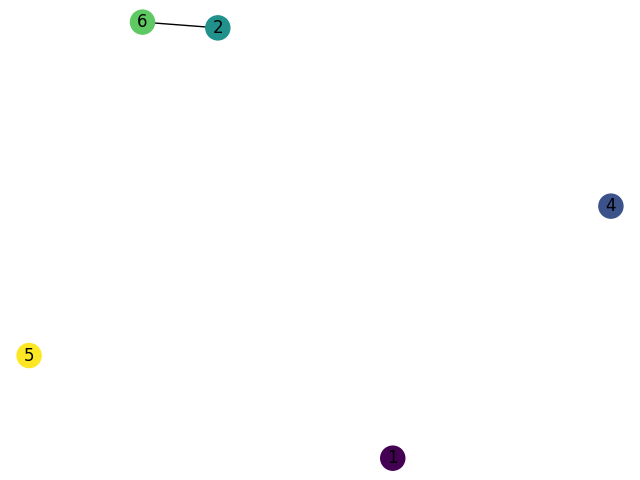

In [243]:
misc.draw(G, getColoring())

# Big Bucket Algorithm

# Testing and Drawing

In [ ]:
coloring = nx.coloring.greedy_color(G, strategy=nx.coloring.strategy_largest_first)

In [ ]:
layout = nx.spring_layout(G)

In [ ]:
c = misc.combineColorings([coloring, coloring2])

NameError: name 'coloring2' is not defined

In [ ]:
G2 = G.subgraph([0,1,2,3])
G3 = G.subgraph([4,5,6,7,8,9])